## Project Stage - III (Basic Machine Learning)

## Goals

The goal of Stage II is to utlize machine learning and statistical models to predict the trend of COVID-19 cases / deaths.

### Tasks:

#### Task 1: (70 pts)
- Team: (30)
    - Develop Linear and Non-Linear (polynomial) regression models for predicting cases and deaths in US. 
        - Start your data from the first day of infections in US. X-Axis - number of days since the first case, Y-Axis - number of new cases and deaths.
        - Calculate and report Root Mean Square Error (RMSE) for your models (linear and non-linear). Discuss bias versus variance tradeoff.
        - Plot trend line along for the data along with the forecast of 1 week ahead. 
        - Describe the trends as compared to other countries. 
- Member: (40 pts)
    - Utilize Linear and Non-Linear (polynomial) regression models to compare trends for a single state and its counties (top 5 with highest number of cases). Start your data from the first day of infections. 
        - X-Axis - number of days since the first case, Y - Axis number of new cases and deaths. Calcluate error using RMSE.
        - Identify which counties are most at risk. Model for top 5 counties with cases within a state and describe their trends.
        - Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.
     - Perform hypothesis tests on questions identified in Stage II
        - e.x. *Does higher employment data (overall employment numbers) lead to higher covid case numbers or more rapid increase in covid cases.*. Here you would compare the covid cases to the state or county level enrichment data to prove or disprove your null hypothesis. In this case there will be a two tail - two sample t-test to see if there is a difference and then one-tail - two sample t-test to show higher or lower.
        - Depending on your type of data you can also perform Chi-square test for categorical hypothesis testing. 

    
#### Task 2: (30 pts)
- Member:
    - For each of the aforemention analysis plot graphs,
        - trend line
        - confidence intervals (error in prediction)
        - prediction path (forecast)

**Deliverable**
- Each member creates separate notebooks for member tasks. Upload all notebooks and reports to Github Repository. 
- Presentation recordings on canvas.

<h1>Task 1</h1>

<h3>First of all, Let's import everything we need.</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import scipy.stats as stats
import scipy as sc
import math

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

import os

if not os.path.exists("../../../../data/stage_III/images_Ashim"):
    os.mkdir("../../../../data/stage_III/images_Ashim")


<h3>Reading all the necessary Data. </h3>

In [2]:
cases = pd.read_csv("../../../../data/stage_I/covid_confirmed_usafacts.csv", delimiter=",")
deaths = pd.read_csv("../../../../data/stage_I/covid_deaths_usafacts.csv", delimiter=",")
population = pd.read_csv("../../../../data/stage_I/covid_county_population_usafacts.csv", delimiter=",")

<h3>Creating required dataframes and gathering required data.</h3>

In [3]:
#Creating new dataframe for the state of Washington
w_cases= cases[cases['State']=='WA']
w_deaths = deaths[deaths['State']=='WA']

#Dropping state fips because we don't need that
w_cases = w_cases.drop(['StateFIPS'], axis=1)
w_deaths = w_deaths.drop(['StateFIPS'], axis=1)

#Setting indexes
w_cases = w_cases.set_index(['countyFIPS','County Name','State'])
w_deaths = w_deaths.set_index(['countyFIPS','County Name','State'])

#Getting the population of Washington
w_population = population[population['State']=='WA'].sum()
w_population = w_population['population']

<h3>Dataframe w_dfc is going to serve as the dataframe to calculate our linear and non-linear regression model for cases and w_dfd is going to serve for deaths.</h3>

In [4]:
#For cases.
#Creating a new dataframe to calculate linear regression. All the dates are being converted into a list.
w_dfc = pd.DataFrame(w_cases.columns.values.tolist()).reset_index()

#Renaming the columns
w_dfc = w_dfc.rename(columns = {'index' : 'Day', 0 : 'Date'});

#Adding 1 so that the Day column starts from 1
w_dfc['Day']+=1

#Adding daily cases and deaths to the dataframe.
w_dfc['Cases']=list(w_cases.sum())

#For deaths.
w_dfd = pd.DataFrame(w_deaths.columns.values.tolist()).reset_index()

#Renaming the columns
w_dfd = w_dfd.rename(columns = {'index' : 'Day', 0 : 'Date'});

#Adding 1 so that the Day column starts from 1
w_dfd['Day']+=1

#Adding daily cases and deaths to the dataframe.
w_dfd['Deaths'] = list(w_deaths.sum())

### The code below is to make sure, the first day of the death starts with the at least 1 death.

In [5]:
#First we find the first value in the column that starts greater than 0.
value_w_dfd = next(x for x, val in enumerate (w_dfd['Deaths']) if val > 0)

#We drop all the columns before that value.
w_dfd = w_dfd.drop(range(0,value_w_dfd)).reset_index()

#We remove the old columns we don't need.
w_dfd = w_dfd.drop(['index'], axis = 1)

#We update our day column
w_dfd['Day'] = w_dfd.index
w_dfd['Day'] += 1

### Calculating the difference in cases and deaths everyday.

In [6]:
w_dfc['Cases'] = w_dfc['Cases'].diff().fillna(1)
w_dfd['Deaths'] = w_dfd['Deaths'].diff().fillna(1)

w_dfc['Cases'] = w_dfc['Cases'].abs()
w_dfd['Deaths']= w_dfd['Deaths'].abs()

### So, Let's normalize the population for our cases and deaths. We are going to normalize the population by 100,000.

In [7]:
w_dfc['Cases']= (w_dfc['Cases']/w_population)*100000
w_dfd['Deaths']= (w_dfd['Deaths']/w_population)*100000

<h3> We need number of days for our x-axis and Cases and Deaths for our y-axis which is in our w_dfc and w_dfd which can be seen below. Let's develop linear and polynomial regression model to compare the trends for a single state. </h3>

### Below, I am creating a method to calculate all the necessary models and print it out.

In [8]:
#for def linear_regression
#Pass X = value for x axis in linear regression, y = value for y axis in linear regression.
#Pass types = 'cases' or 'deaths' and geography = 'name of state or county'
#Pass df takes dataframe name and type_marker takes 'Cases' or 'Deaths'
range_of_day = 14

def linear_regression(X , y, types, geography, df, type_marker, a):
    lm_a = LinearRegression()
    lm_a.fit(X,y)

    print('The intercept for ' + types + ' of '+ geography + ' is :', lm_a.intercept_ )
    print('The coefficient for ' + types + ' of '+ geography + ' is :', lm_a.coef_)
    X_min_max = pd.DataFrame({'Day':[X.Day.min(), X.Day.max()]})
    y_pred_a = lm_a.predict(X)
    
    rmse_a = np.sqrt(mean_squared_error(y.tolist(), y_pred_a.tolist()))
    print('RMSE for linear regression of ' + types + ' of ' + geography + ' is : {}'.format(rmse_a))

    #Non-Linear Regression. (degree = 4)
    degree_first = 4
    non_linear_a = make_pipeline(PolynomialFeatures(degree_first), LinearRegression())
    poly_2_a = non_linear_a.fit(X,y)
    non_linear_y_pred_a = poly_2_a.predict(X)
    rmse_non_linear_a = np.sqrt(mean_squared_error(y.tolist(),non_linear_y_pred_a.tolist()))
    print('RMSE for polynomial regression degree 2 of ' + types + ' of ' + geography + ' is :{}'.format(rmse_non_linear_a))
    
    #Non-Linear Regression. (degree = 7)
    degree_second = 7
    non_linear_3_a =make_pipeline(PolynomialFeatures(degree_second), LinearRegression())
    poly_3 = non_linear_3_a.fit(X,y)
    non_linear_y_pred_3_a = poly_3.predict(X)
    rmse_non_linear_3_a = np.sqrt(mean_squared_error(y.tolist(),non_linear_y_pred_3_a.tolist()))
    print('RMSE for polynomial regression degree 3 of ' + types + ' of ' + geography + ' is : {}'.format(rmse_non_linear_3_a))
    
    #Adding traces to create a graph with the best-fit lines.
    trace0_a = go.Scatter(
                        x = df['Day'],
                        y = df[type_marker],
                        name = type_marker,
                        mode = "markers",
                        marker = dict(color = 'rgba(0, 0, 128, 0.5)'))
    trace1_a = go.Scatter(x = X['Day'].values.tolist(),
                           y = y_pred_a.tolist(),
                           mode = "lines",
                           name = 'Linear Regression %.2f' %rmse_a)
    trace2_a = go.Scatter(x = X['Day'].values.tolist(),
                           y = non_linear_y_pred_a.tolist(),
                           mode = "lines",
                           name = 'Polynomial Regression Degree = 2 %.2f' %rmse_non_linear_a)
    trace3_a = go.Scatter(x = X['Day'].values.tolist(),
                           y = non_linear_y_pred_3_a.tolist(),
                           mode = "lines",
                           name = 'Polynomial Regression Degree = 3 %.2f' %rmse_non_linear_3_a)
    data_a = [trace0_a, trace1_a, trace2_a, trace3_a]
    layout_a = go.Layout(title ='New ' + types + ' in ' + geography)
    fig_a = go.Figure(data=data_a, layout= layout_a)
    fig_a.update_layout(autosize = False, 
                      width=1000, 
                      height = 720, 
                      legend=dict(yanchor="top", y=0.99 ,xanchor="left", x=0.01))
    iplot(fig_a)
    a = str(a)
    fig_a.write_image("../../../../data/stage_III/images_Ashim/fig_" + a + ".jpeg")
    


In [9]:
def prediction_cases(X, y, df, type_marker, b):
    final_day = df['Day'][df.index[-1]]
    for i in (number+1 for number in range(range_of_day)):
        day = final_day + i
        add_days = {'Day': day, type_marker : 0}
        df = df.append(add_days, ignore_index=True)
    
    lm_a = LinearRegression()
    lm_a.fit(X,y)
    degree_second = 7
    non_linear_3_a =make_pipeline(PolynomialFeatures(degree_second), LinearRegression())
    poly_3 = non_linear_3_a.fit(X,y)
    non_linear_y_pred_3_a = poly_3.predict(X)
    
    new_df = df.iloc[-range_of_day:]
    n_day = ['Day']
    X = new_df[n_day]
    y = new_df.Cases
    new_pred = poly_3.predict(X)

    trace0_b = go.Scatter(
                        x = new_df['Day'],
                        y = new_pred.tolist(),
                        name = 'Cases',
                        mode = "markers",
                        marker = dict(color = 'rgba(0, 0, 128, 0.5)'))
    data_b = [trace0_b]
    layout_b = go.Layout(title ='Prediction')
    fig_b = go.Figure(data=data_b, layout= layout_b)
    fig_b.update_layout(autosize = False, 
                          width=1000, 
                          height = 720, 
                          legend=dict(yanchor="top", y=0.99 ,xanchor="left", x=0.01))
    iplot(fig_b)
    b = str(b)
    fig_b.write_image("../../../../data/stage_III/images_Ashim/fig_" + b + b + b + ".jpeg")
    
def prediction_deaths(X, y, df, type_marker, b):
    final_day = df['Day'][df.index[-1]]
    for i in (number+1 for number in range(range_of_day)):
        day = final_day + i
        add_days = {'Day': day, type_marker : 0}
        df = df.append(add_days, ignore_index=True)
    
    lm_a = LinearRegression()
    lm_a.fit(X,y)
    degree_second = 7
    non_linear_3_a =make_pipeline(PolynomialFeatures(degree_second), LinearRegression())
    poly_3 = non_linear_3_a.fit(X,y)
    non_linear_y_pred_3_a = poly_3.predict(X)
    
    new_df = df.iloc[-range_of_day:]
    n_day = ['Day']
    X = new_df[n_day]
    y = new_df.Deaths
    new_pred = poly_3.predict(X)

    trace0_b = go.Scatter(
                        x = new_df['Day'],
                        y = new_pred.tolist(),
                        name = 'Deaths',
                        mode = "markers",
                        marker = dict(color = 'rgba(0, 0, 128, 0.5)'))
    data_b = [trace0_b]
    layout_b = go.Layout(title ='Prediction')
    fig_b = go.Figure(data=data_b, layout= layout_b)
    fig_b.update_layout(autosize = False, 
                          width=1000, 
                          height = 720, 
                          legend=dict(yanchor="top", y=0.99 ,xanchor="left", x=0.01))
    iplot(fig_b)
    b = str(b)
    fig_b.write_image("../../../../data/stage_III/images_Ashim/fig_" + b + b + b + ".jpeg")
    

### Now, the graphs for the state of Washington.

In [10]:
days = ['Day']
X = w_dfc[days]
y = w_dfc.Cases
linear_regression(X,y, 'cases' , 'Washinton State', w_dfc, 'Cases', 1)
prediction_cases(X,y,w_dfc, 'Cases', 1)

The intercept for cases of Washinton State is : -2.700914745611774
The coefficient for cases of Washinton State is : [0.06839081]
RMSE for linear regression of cases of Washinton State is : 20.717586216549996
RMSE for polynomial regression degree 2 of cases of Washinton State is :19.59715406481834
RMSE for polynomial regression degree 3 of cases of Washinton State is : 19.08910300284803


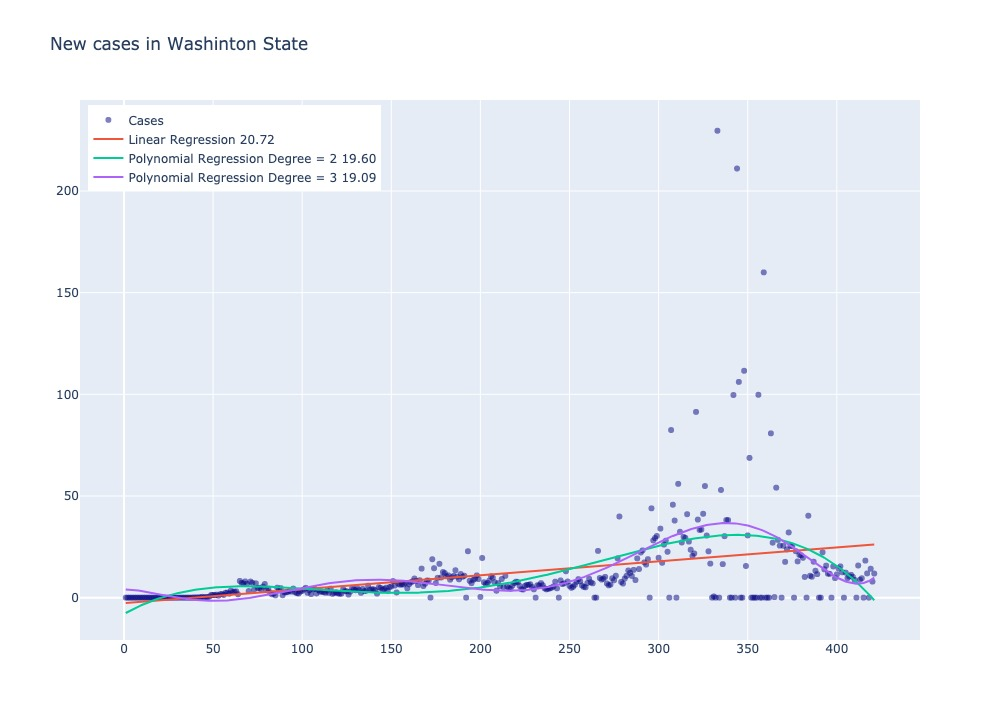

In [11]:
Image("../../../../data/stage_III/images_Ashim/fig_1.jpeg")

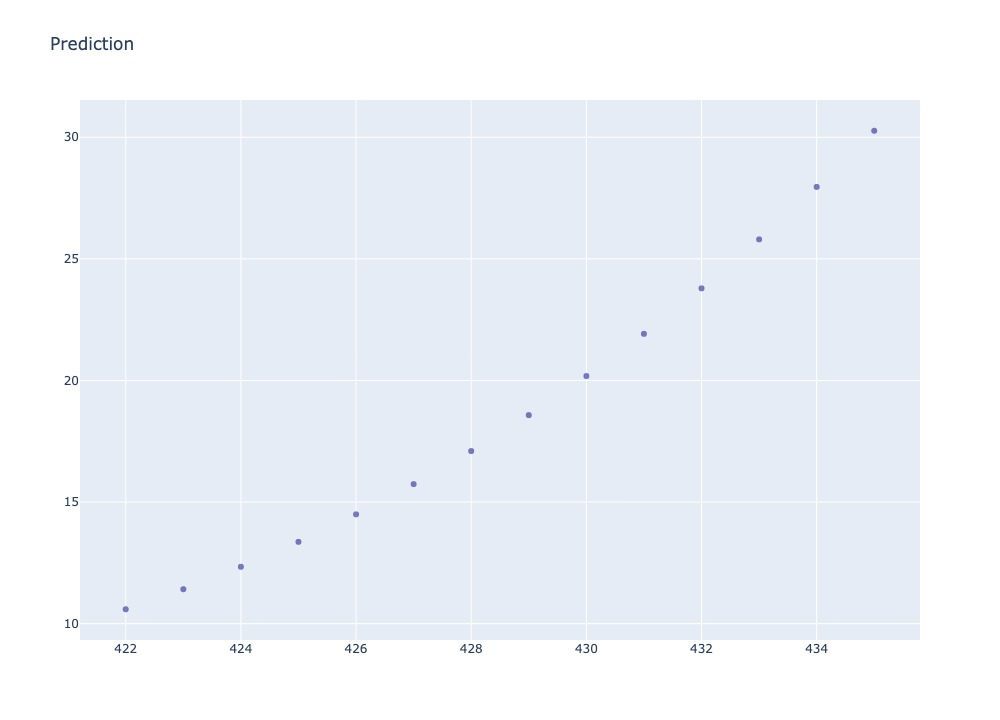

In [12]:
Image("../../../../data/stage_III/images_Ashim/fig_111.jpeg")

In [13]:
days = ['Day']
X = w_dfd[days]
y = w_dfd.Deaths
linear_regression(X,y, 'deaths' , 'Washinton State', w_dfd, 'Deaths', 2)
prediction_deaths(X,y,w_dfd, 'Deaths', 2)

The intercept for deaths of Washinton State is : 0.08102112247402043
The coefficient for deaths of Washinton State is : [0.00058879]
RMSE for linear regression of deaths of Washinton State is : 0.32783719866031447
RMSE for polynomial regression degree 2 of deaths of Washinton State is :0.3161197278520776
RMSE for polynomial regression degree 3 of deaths of Washinton State is : 0.31536788755886264


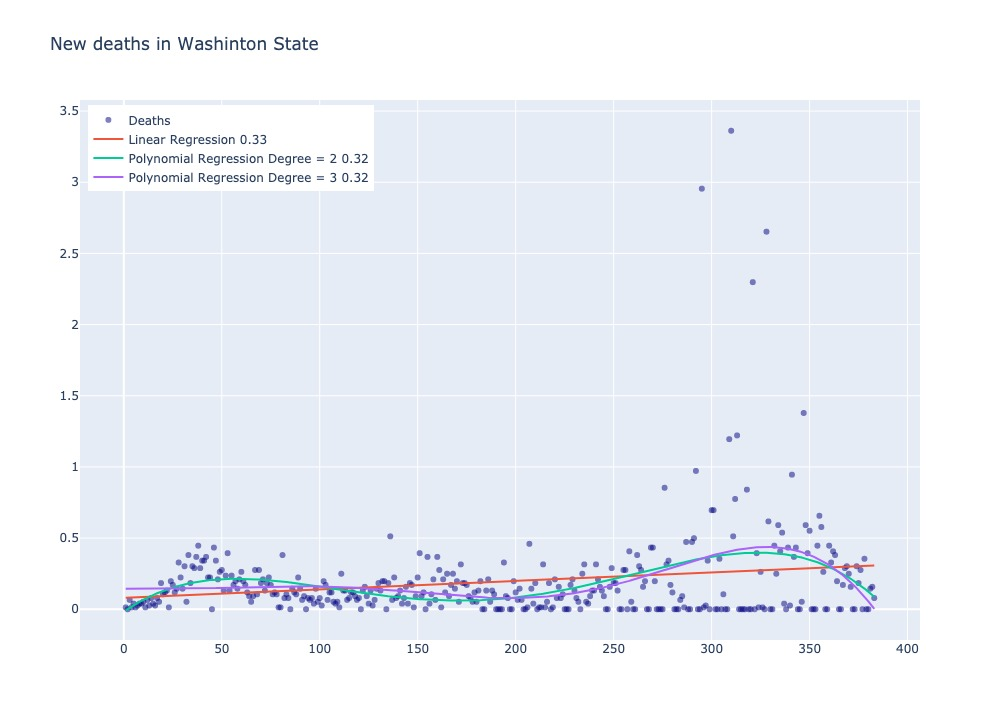

In [14]:
Image("../../../../data/stage_III/images_Ashim/fig_2.jpeg")

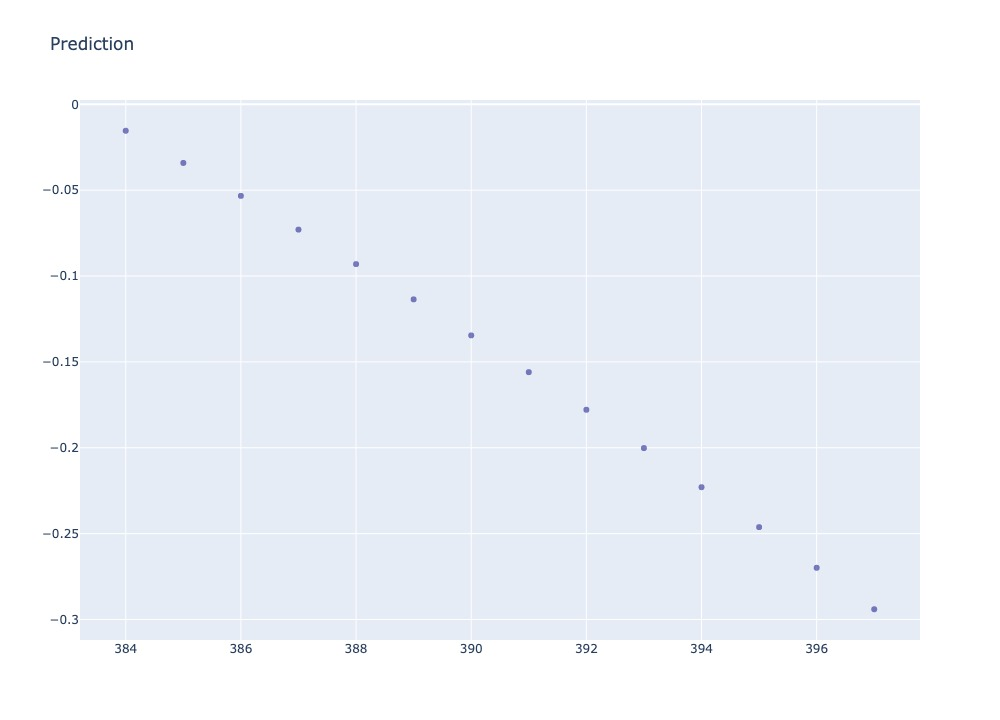

In [15]:
Image("../../../../data/stage_III/images_Ashim/fig_222.jpeg")

### Let's get the data for counties.

In [16]:
#Let's get the top 5 counties. Our dataframe w_cases holds the cumulative sum in the final column.
get_county_df = w_cases.iloc[:,-1:]

#Let's get the top 5 counties and set the index as countyFIPS(currently the dataframe has 3 indexes)
get_county_df = get_county_df.nlargest(5,get_county_df.iloc[:,-1:])
get_county_df.index = get_county_df.index.get_level_values('countyFIPS')

#A new dataframe with only the 5 states we need.
top_5 = cases[cases['countyFIPS'].isin(get_county_df.index)]

### Showing the top 5 counties.

In [17]:
top_5

countyFIPS        County Name State  StateFIPS  2020-01-22  2020-01-23  \
3017       53033       King County     WA         53           1           1   
3027       53053     Pierce County     WA         53           0           0   
3031       53061  Snohomish County     WA         53           0           0   
3032       53063    Spokane County     WA         53           0           0   
3039       53077     Yakima County     WA         53           0           0   

      2020-01-24  2020-01-25  2020-01-26  2020-01-27  ...  2021-03-08  \
3017           1           1           1           1  ...       85282   
3027           0           0           0           0  ...       39272   
3031           0           0           0           0  ...       30651   
3032           0           0           0           0  ...       36892   
3039           0           0           0           0  ...       27060   

      2021-03-09  2021-03-10  2021-03-11  2021-03-12  2021-03-13  2021-03-14  \
3017       85417       85596       85596       86002       86234       86234   
3027       39367       39485       39485       39728       39857       39857   
3031       30712       30759       30759       30832       30883       30883   
3032       36933       37008       37008       37153       37228       37228   
3039       27099       27134       27134       27241       27313       27313   

      2021-03-15  2021-03-16  2021-03-17  
3017       86540       86655       86850  
3027       40028       40172       40380  
3031       30972       31013       31069  
3032       37323       37381       37470  
3039       27349       27411       27441  

[5 rows x 425 columns]

### Getting the population for 5 counties.

In [18]:
population_5 = population[population['countyFIPS'].isin(get_county_df.index)]
ki_popn = population_5['population'].iloc[0]
pi_popn = population_5['population'].iloc[1]
sn_popn = population_5['population'].iloc[2]
sp_popn = population_5['population'].iloc[3]
ya_popn = population_5['population'].iloc[4] 

### I have defined two functions below for cases and deaths of 5 different counties.

In [19]:
def county_cases(x,i,name,popn,a):
    x = pd.DataFrame(w_cases.columns.values.tolist()).reset_index()
    x = x.rename(columns = {'index' : 'Day', 0 : 'Date'});
    x['Day']+=1
    x['Cases']= list(w_cases.iloc[1])

    value_x = next(z for z, val in enumerate (x['Cases']) if val > 0)
    x = x.drop(range(0,value_x)).reset_index()
    x = x.drop(['index'], axis = 1)
    x['Day'] = x.index
    x['Day'] += 1

    x['Cases'] = x['Cases'].diff().fillna(1)

    x['Cases'] = x['Cases'].abs()

    x['Cases']= (x['Cases']/popn)*100000

    days = ['Day']
    X = x[days]
    y = x.Cases
    linear_regression(X,y, 'cases' , name, x, 'Cases', a)
    prediction_cases(X,y, x, 'Cases', a)

In [20]:
def county_deaths(x,i,name,popn,a):
    x = pd.DataFrame(w_deaths.columns.values.tolist()).reset_index()
    x = x.rename(columns = {'index' : 'Day', 0 : 'Date'});
    x['Day']+=1
    x['Deaths']= list(w_deaths.iloc[i])

    value_x = next(z for z, val in enumerate (x['Deaths']) if val > 0)
    x = x.drop(range(0,value_x)).reset_index()
    x = x.drop(['index'], axis = 1)
    x['Day'] = x.index
    x['Day'] += 1

    x['Deaths'] = x['Deaths'].diff().fillna(1)

    x['Deaths'] = x['Deaths'].abs()

    x['Deaths']= (x['Deaths']/popn)*100000

    days = ['Day']
    X = x[days]
    y = x.Deaths
    linear_regression(X,y, 'deaths' , name, x, 'Deaths', a)
    prediction_deaths(X,y, x, 'Deaths', a)
    

In [21]:
county_cases('k_dfc',0, 'King County', ki_popn, 3)

The intercept for cases of King County is : 0.12768421092045584
The coefficient for cases of King County is : [0.00069575]
RMSE for linear regression of cases of King County is : 0.3671329889049592
RMSE for polynomial regression degree 2 of cases of King County is :0.3489475722120586
RMSE for polynomial regression degree 3 of cases of King County is : 0.342124321861942


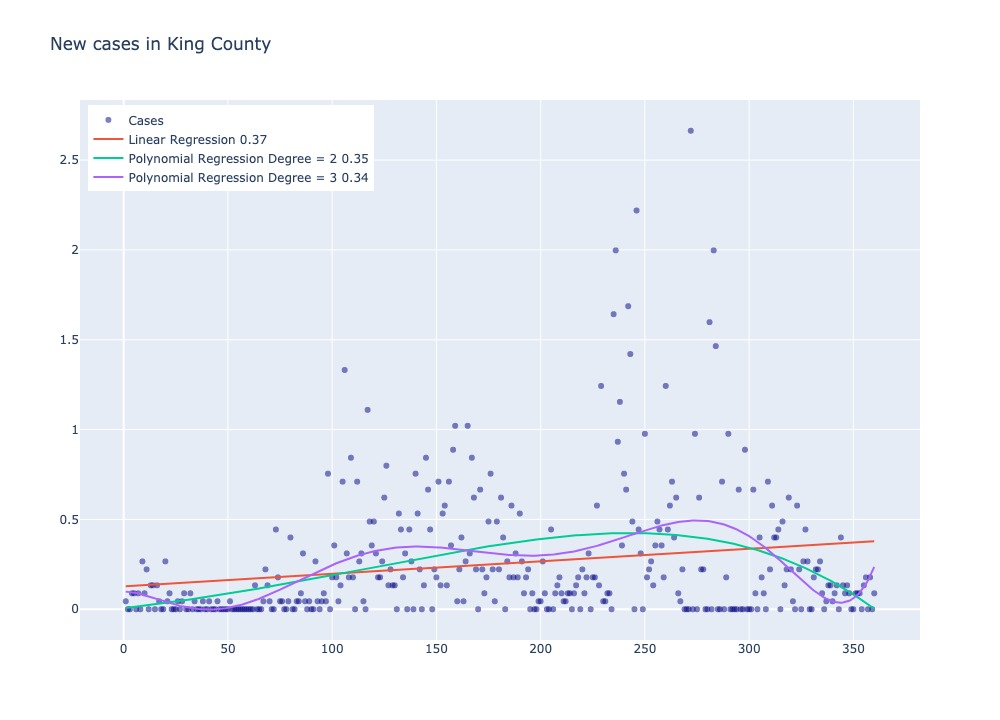

In [22]:
Image("../../../../data/stage_III/images_Ashim/fig_3.jpeg")

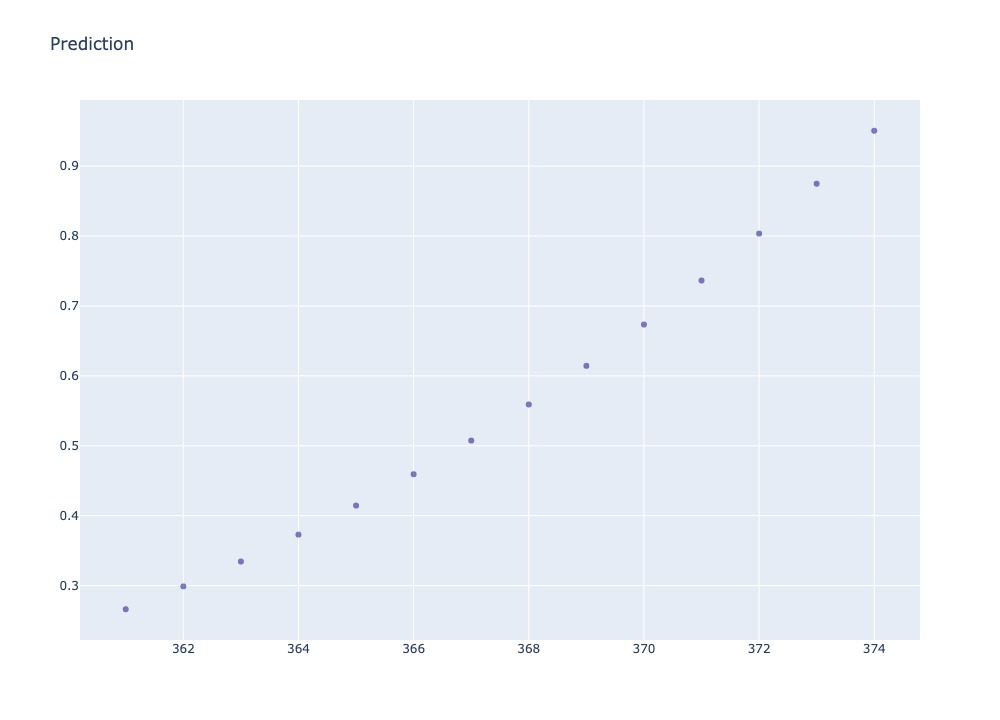

In [23]:
Image("../../../../data/stage_III/images_Ashim/fig_333.jpeg")

In [24]:
county_deaths('k_dfd',0, 'King County', ki_popn, 4)

The intercept for deaths of King County is : 0.017088136031573626
The coefficient for deaths of King County is : [-3.30292459e-05]
RMSE for linear regression of deaths of King County is : 0.02429701700615293
RMSE for polynomial regression degree 2 of deaths of King County is :0.023937735479983898
RMSE for polynomial regression degree 3 of deaths of King County is : 0.023863435616281015


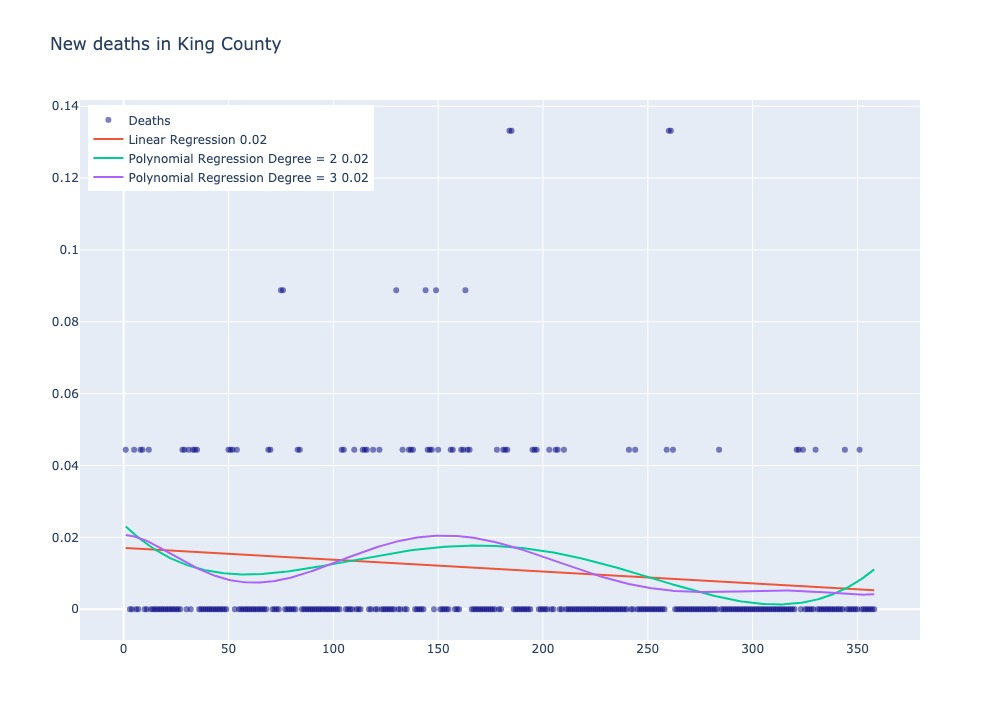

In [25]:
Image("../../../../data/stage_III/images_Ashim/fig_4.jpeg")

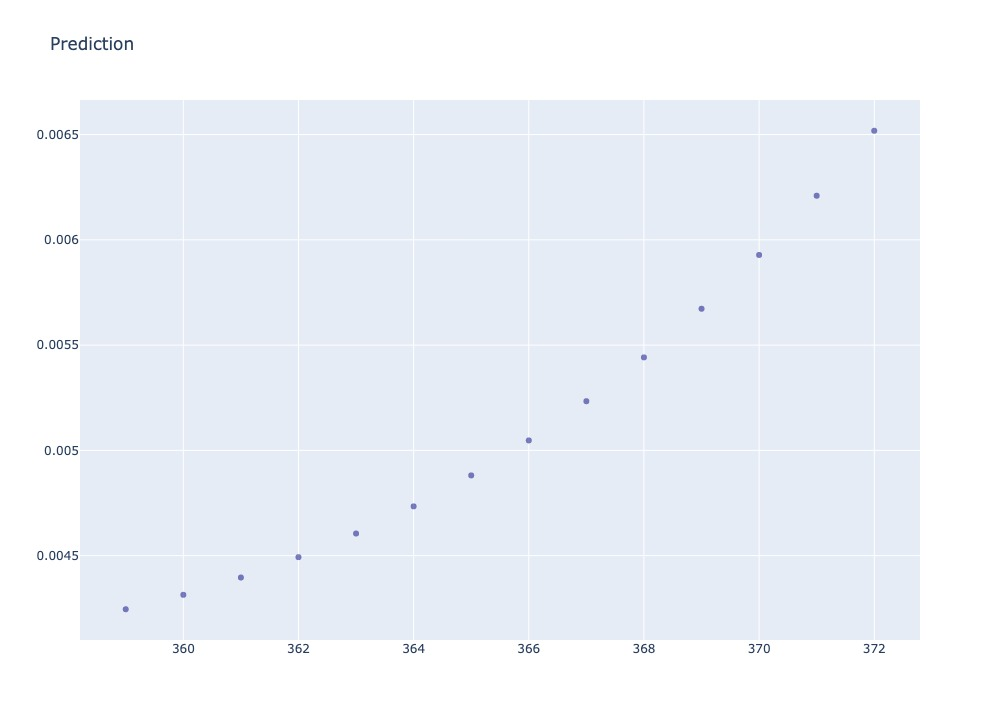

In [26]:
Image("../../../../data/stage_III/images_Ashim/fig_444.jpeg")

In [27]:
county_cases('p_dfc',1, 'Pierce County', pi_popn, 5)

The intercept for cases of Pierce County is : 0.3178464629558735
The coefficient for cases of Pierce County is : [0.00173194]
RMSE for linear regression of cases of Pierce County is : 0.913910350517461
RMSE for polynomial regression degree 2 of cases of Pierce County is :0.8686410855742953
RMSE for polynomial regression degree 3 of cases of Pierce County is : 0.8516559548484124


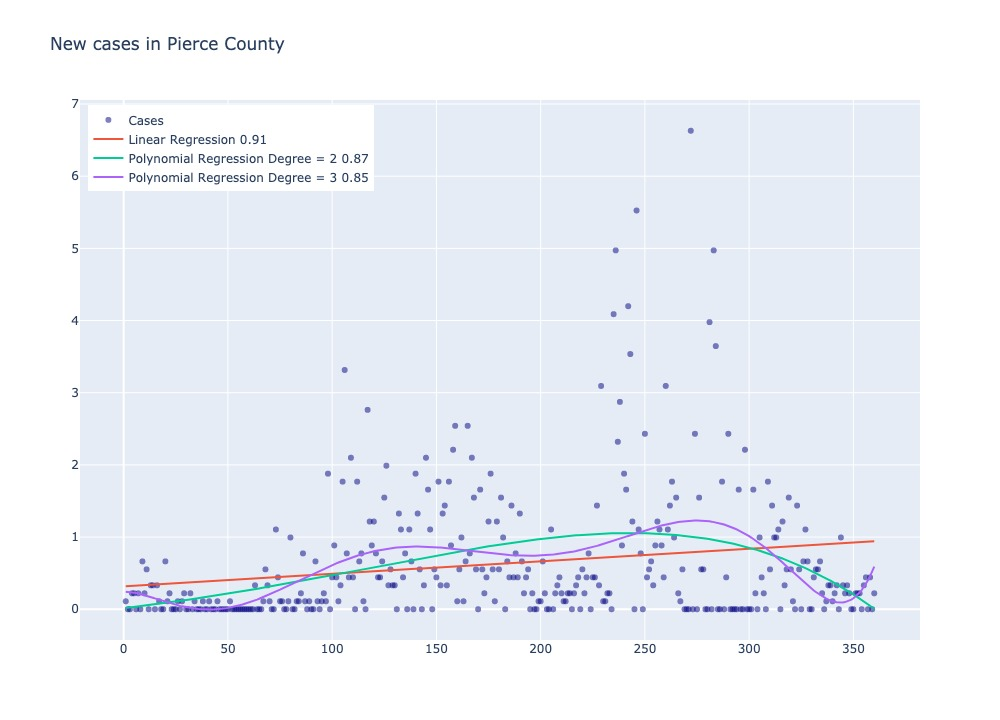

In [28]:
Image("../../../../data/stage_III/images_Ashim/fig_5.jpeg")

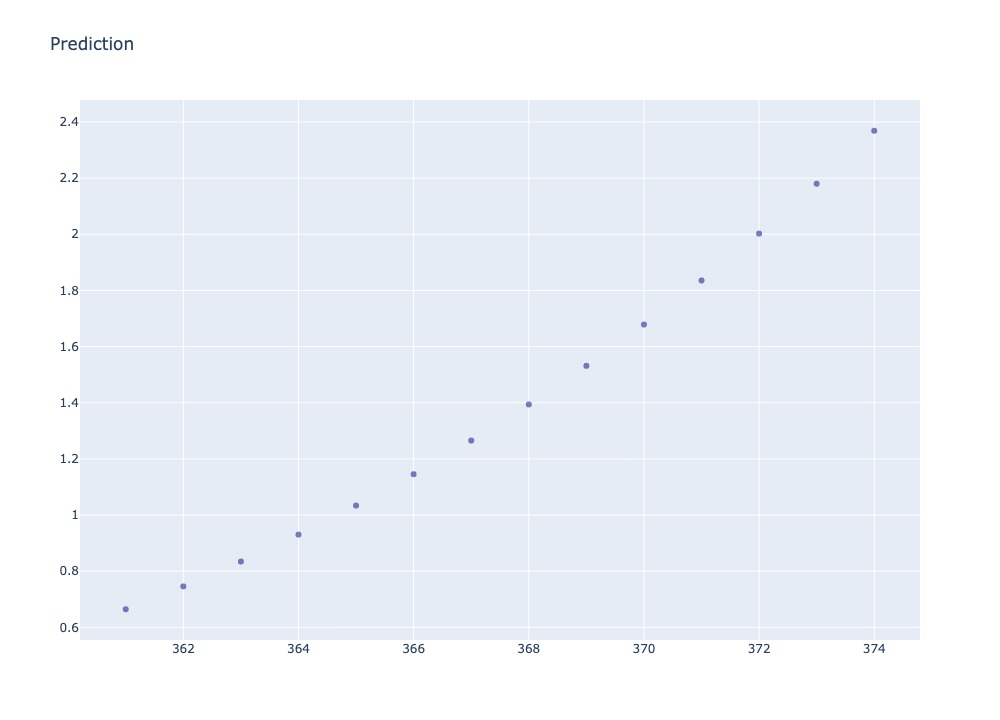

In [29]:
Image("../../../../data/stage_III/images_Ashim/fig_555.jpeg")

In [30]:
county_deaths('p_dfd',1, 'Pierce County', pi_popn, 6)

The intercept for deaths of Pierce County is : 0.015903505989461195
The coefficient for deaths of Pierce County is : [-3.14752108e-05]
RMSE for linear regression of deaths of Pierce County is : 0.04258226099918746
RMSE for polynomial regression degree 2 of deaths of Pierce County is :0.04183032091773335
RMSE for polynomial regression degree 3 of deaths of Pierce County is : 0.04180426953550743


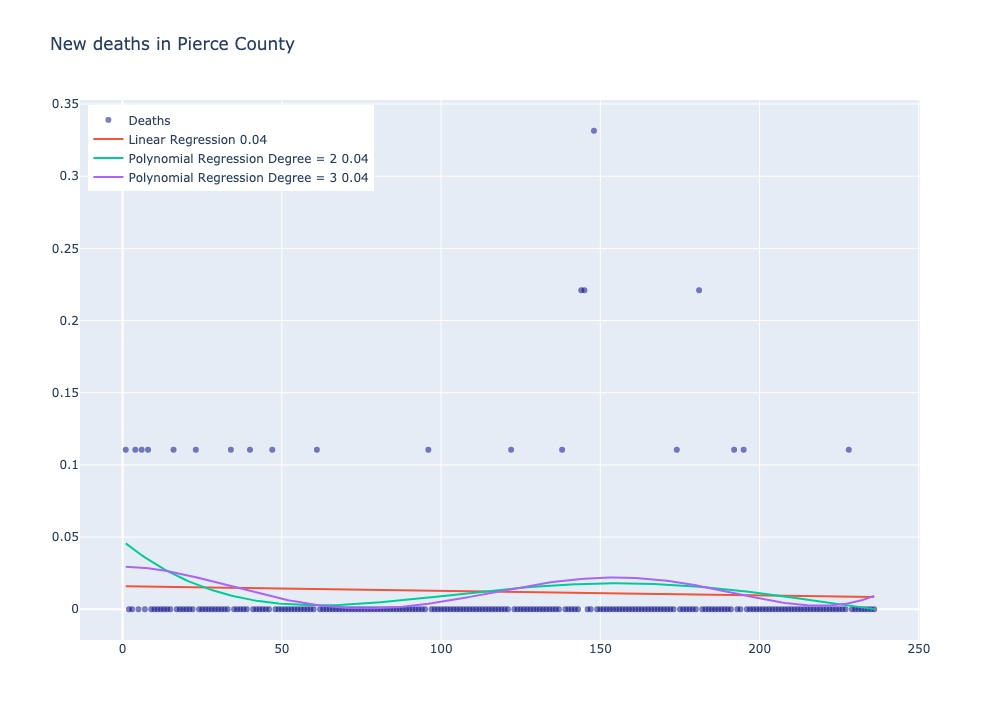

In [31]:
Image("../../../../data/stage_III/images_Ashim/fig_6.jpeg")

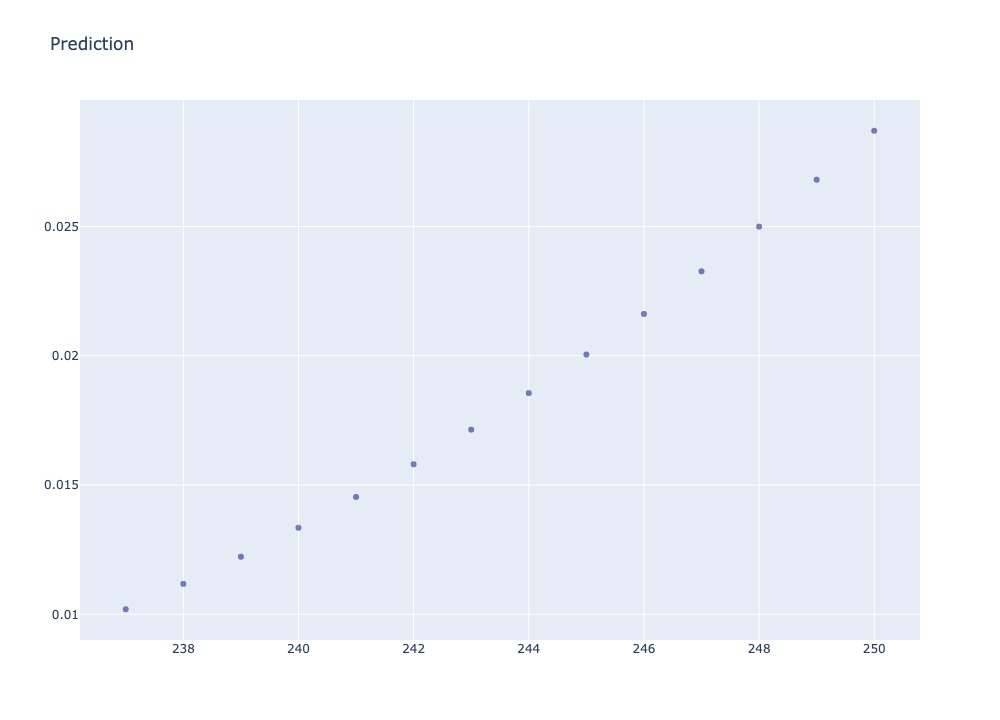

In [32]:
Image("../../../../data/stage_III/images_Ashim/fig_666.jpeg")

In [33]:
county_cases('sn_dfc',2, 'Snohomish County', sn_popn, 7)

The intercept for cases of Snohomish County is : 0.3498973851129464
The coefficient for cases of Snohomish County is : [0.00190659]
RMSE for linear regression of cases of Snohomish County is : 1.006067013928389
RMSE for polynomial regression degree 2 of cases of Snohomish County is :0.9562328981660317
RMSE for polynomial regression degree 3 of cases of Snohomish County is : 0.9375349877646874


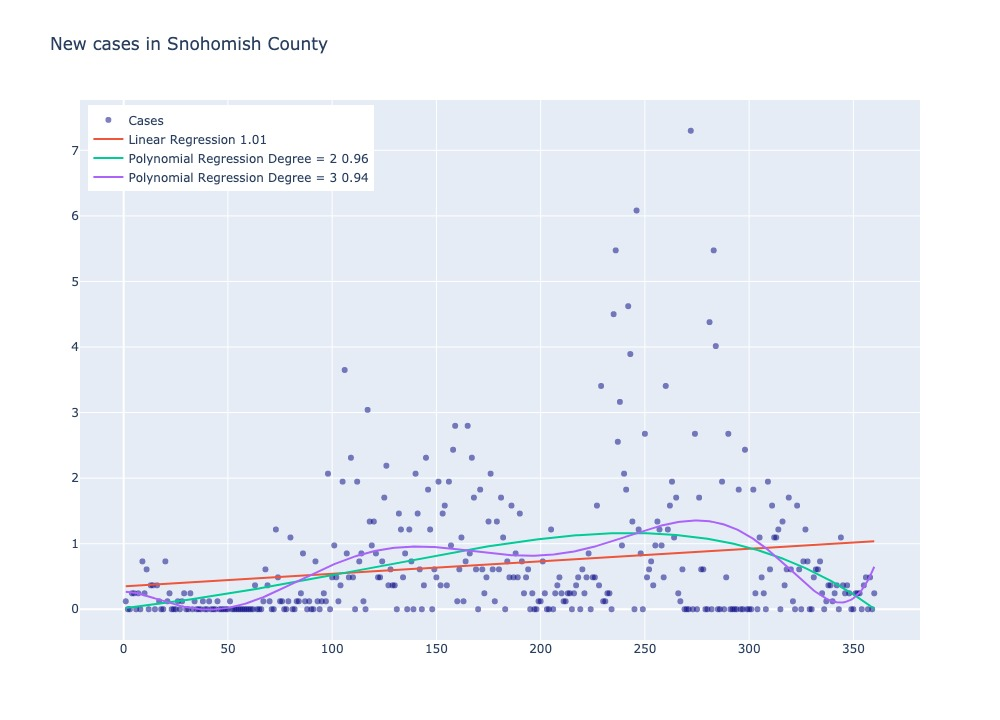

In [34]:
Image("../../../../data/stage_III/images_Ashim/fig_7.jpeg")

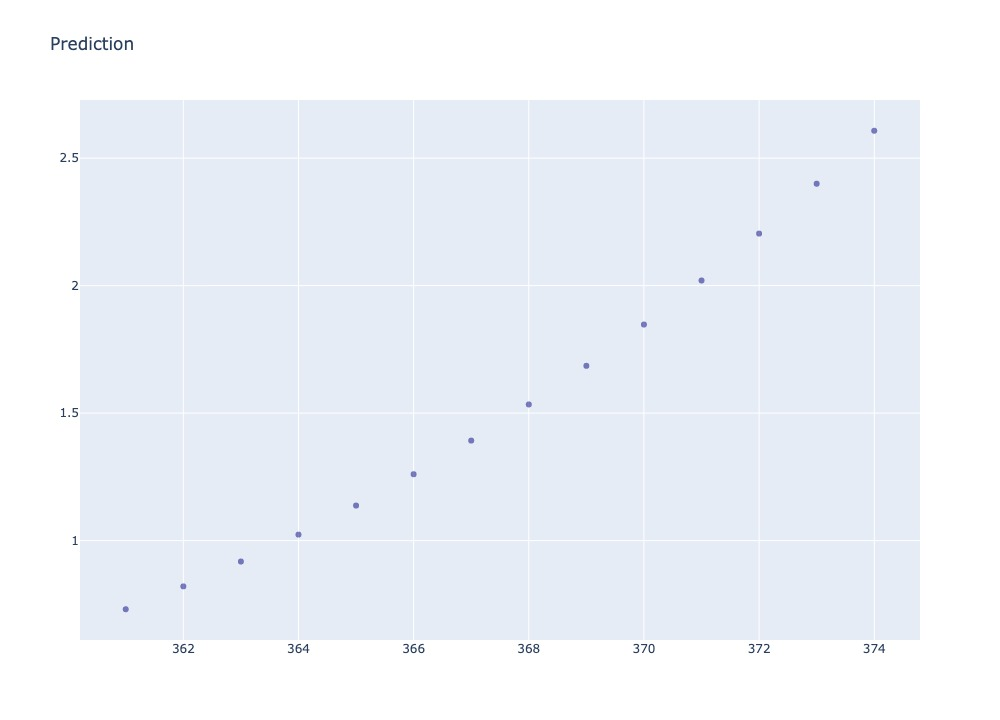

In [35]:
Image("../../../../data/stage_III/images_Ashim/fig_777.jpeg")

In [36]:
county_deaths('sn_dfd',2, 'Snohomish County', sn_popn, 8)

The intercept for deaths of Snohomish County is : 0.00022049948992404825
The coefficient for deaths of Snohomish County is : [6.50871988e-05]
RMSE for linear regression of deaths of Snohomish County is : 0.05767701667009876
RMSE for polynomial regression degree 2 of deaths of Snohomish County is :0.05692015127257145
RMSE for polynomial regression degree 3 of deaths of Snohomish County is : 0.05688893112795971


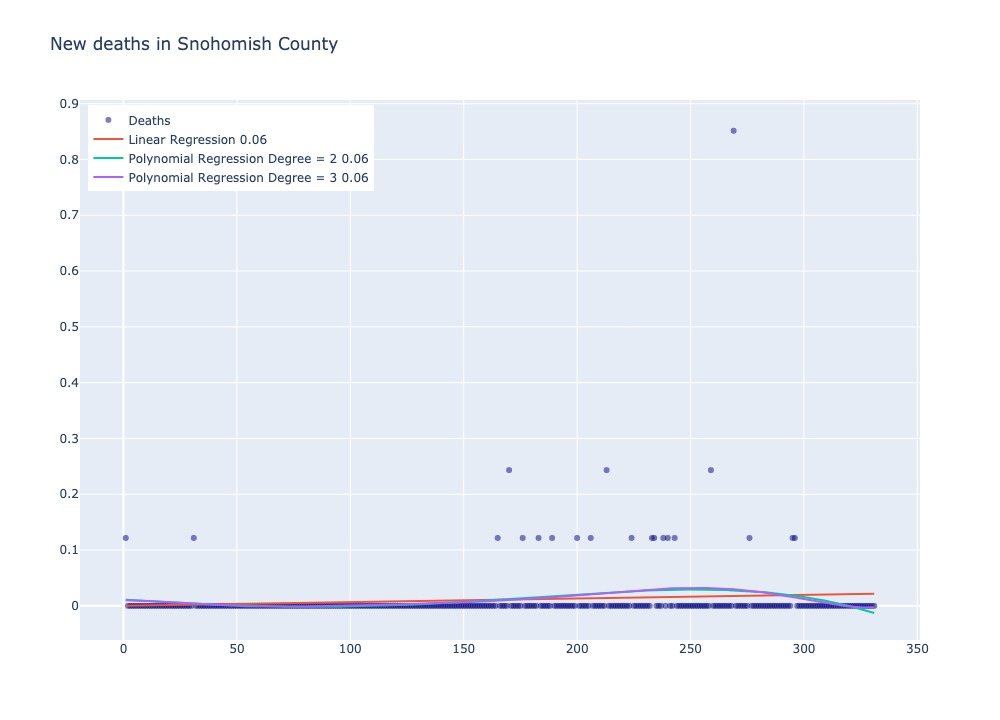

In [37]:
Image("../../../../data/stage_III/images_Ashim/fig_8.jpeg")

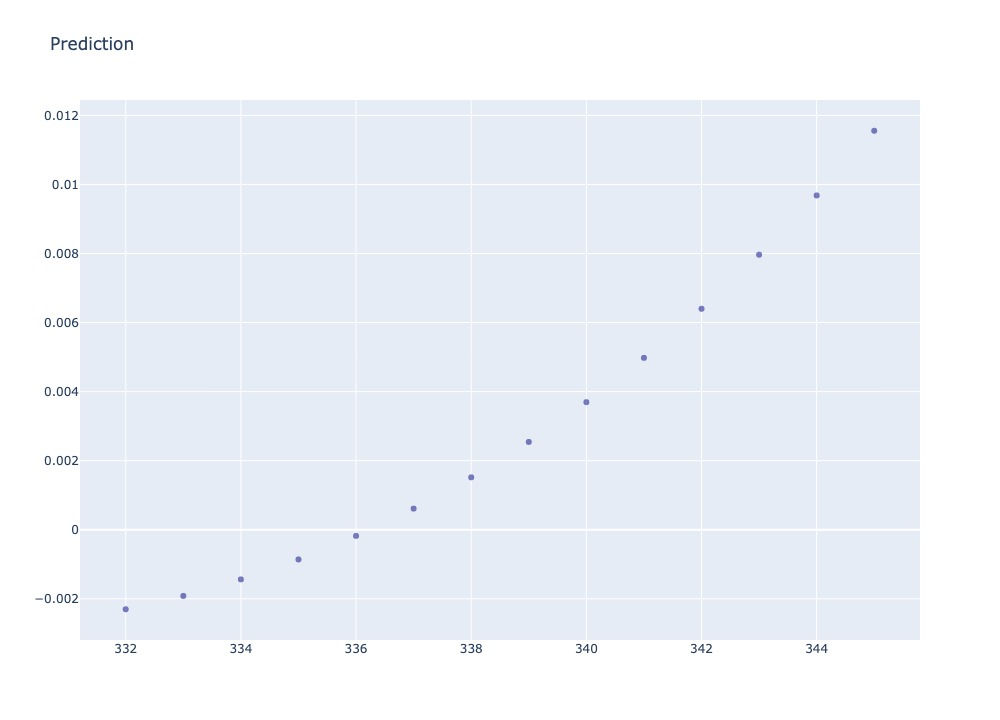

In [38]:
Image("../../../../data/stage_III/images_Ashim/fig_888.jpeg")

In [39]:
county_cases('sp_dfc',3, 'Spokane County', sp_popn, 9)

The intercept for cases of Spokane County is : 0.5502023574034451
The coefficient for cases of Spokane County is : [0.00299805]
RMSE for linear regression of cases of Spokane County is : 1.5820079438163341
RMSE for polynomial regression degree 2 of cases of Spokane County is :1.5036454034312028
RMSE for polynomial regression degree 3 of cases of Spokane County is : 1.47424342149351


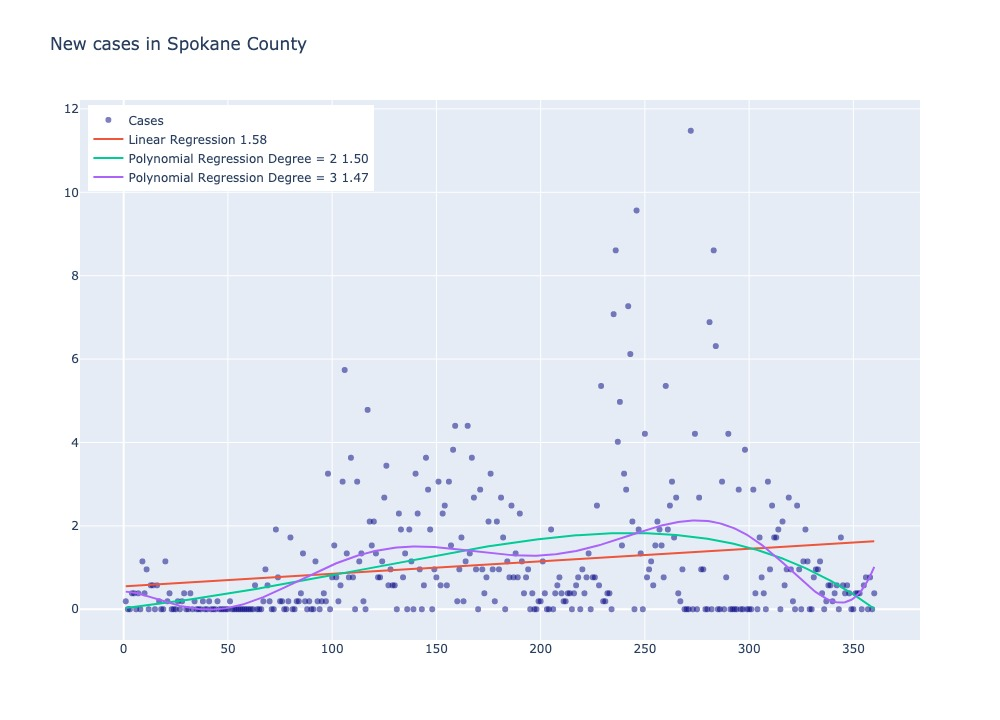

In [40]:
Image("../../../../data/stage_III/images_Ashim/fig_9.jpeg")

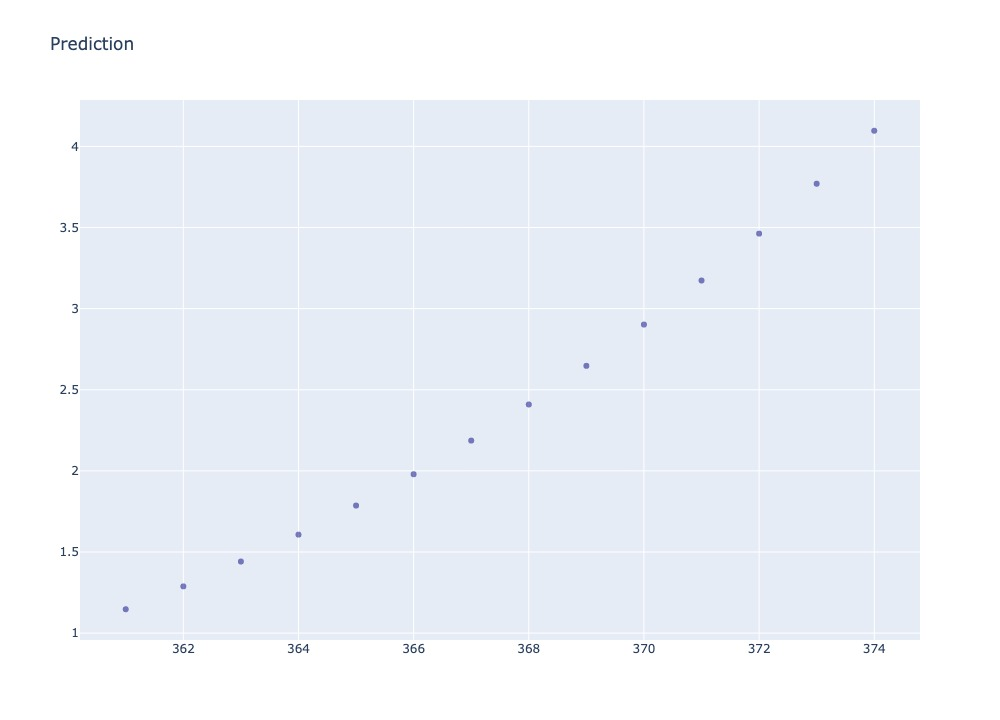

In [41]:
Image("../../../../data/stage_III/images_Ashim/fig_999.jpeg")

In [42]:
county_deaths('sp_dfd',3, 'Spokane County', sp_popn, 10)

The intercept for deaths of Spokane County is : 0.14857912345869628
The coefficient for deaths of Spokane County is : [-9.71618644e-05]
RMSE for linear regression of deaths of Spokane County is : 0.23886267045660078
RMSE for polynomial regression degree 2 of deaths of Spokane County is :0.23404793353366268
RMSE for polynomial regression degree 3 of deaths of Spokane County is : 0.23059433568592683


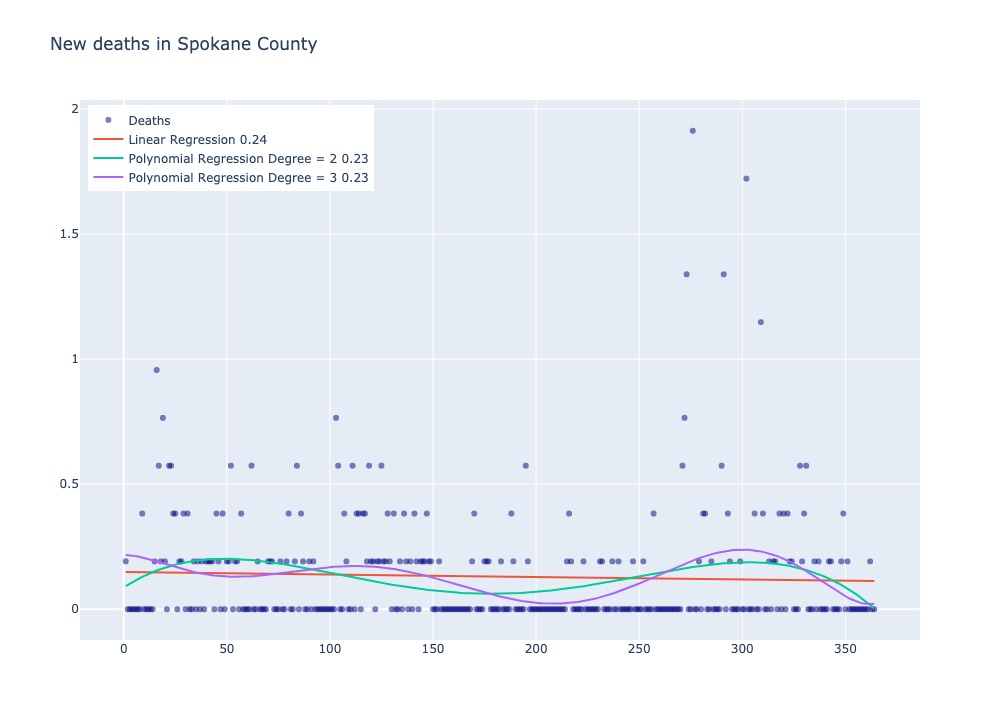

In [43]:
Image("../../../../data/stage_III/images_Ashim/fig_10.jpeg")

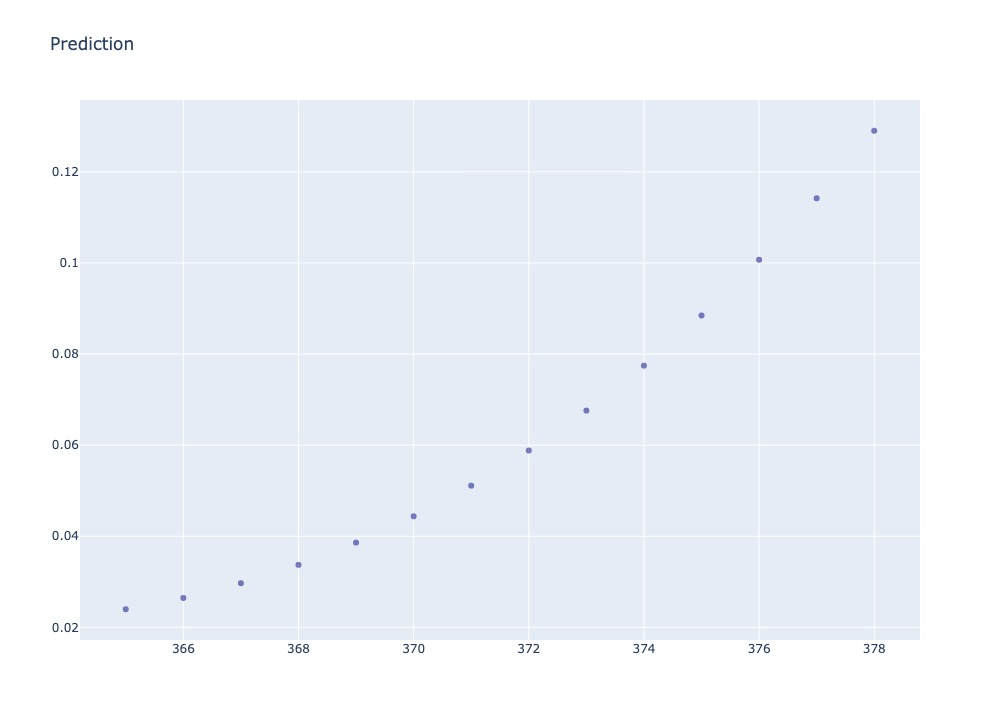

In [44]:
Image("../../../../data/stage_III/images_Ashim/fig_101010.jpeg")

In [45]:
county_cases('y_dfc',4, 'Yakima County', ya_popn, 11)

The intercept for cases of Yakima County is : 1.1465749285327884
The coefficient for cases of Yakima County is : [0.00624768]
RMSE for linear regression of cases of Yakima County is : 3.296770035082658
RMSE for polynomial regression degree 2 of cases of Yakima County is :3.133469164170819
RMSE for polynomial regression degree 3 of cases of Yakima County is : 3.0721984412051193


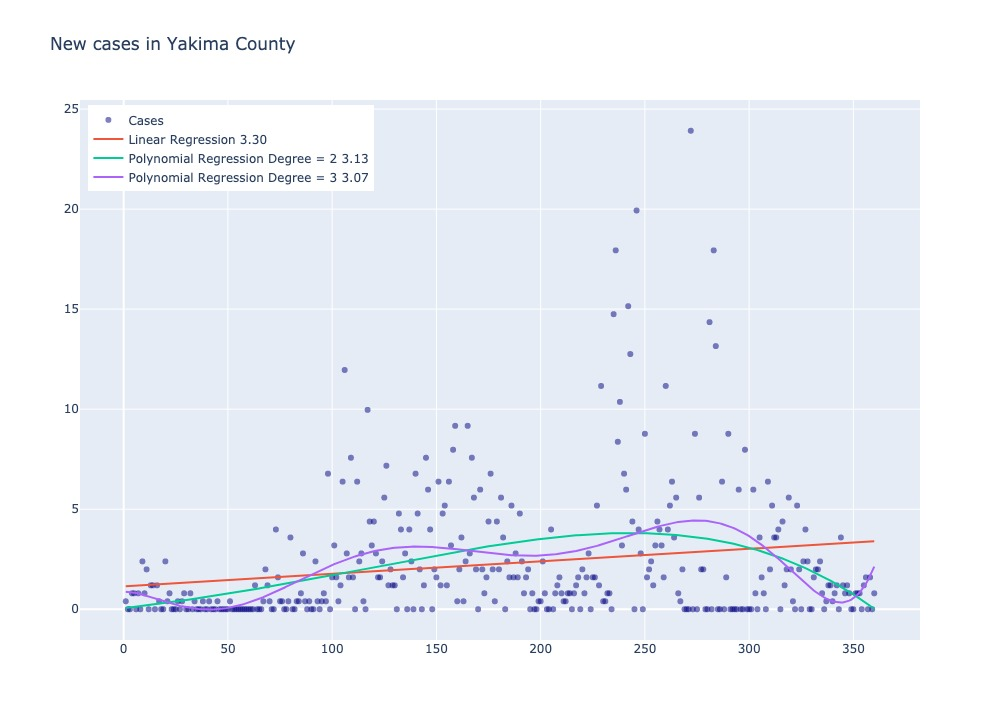

In [46]:
Image("../../../../data/stage_III/images_Ashim/fig_11.jpeg")

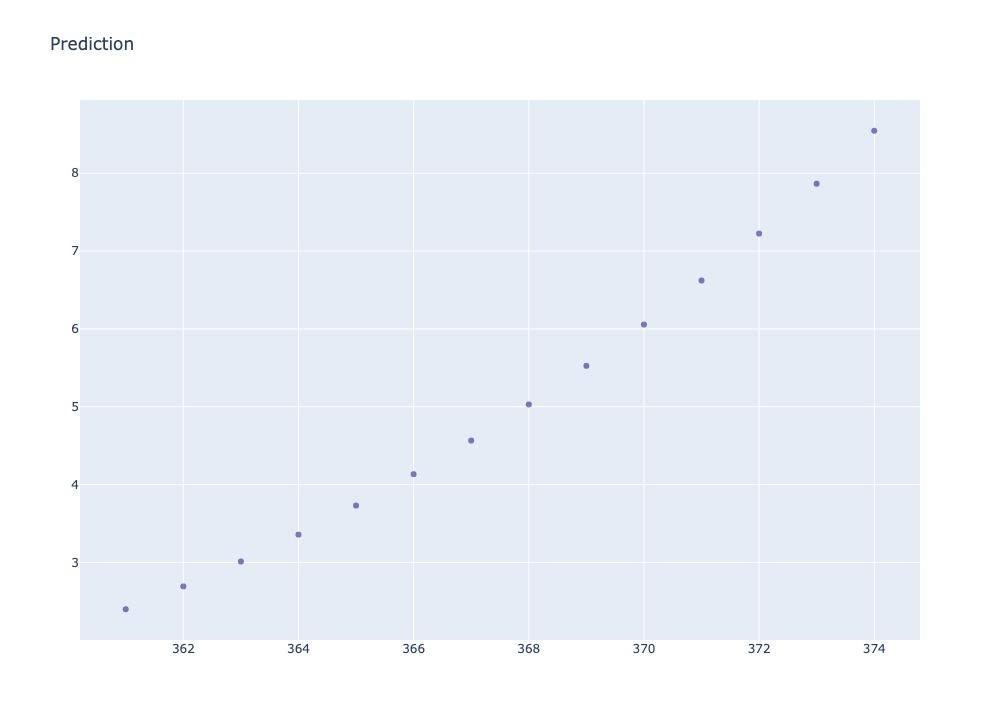

In [47]:
Image("../../../../data/stage_III/images_Ashim/fig_111111.jpeg")

In [48]:
county_deaths('y_dfd',5, 'Yakima County', ya_popn, 12)

The intercept for deaths of Yakima County is : 0.0075030870966519446
The coefficient for deaths of Yakima County is : [6.8819989e-05]
RMSE for linear regression of deaths of Yakima County is : 0.07549590338637287
RMSE for polynomial regression degree 2 of deaths of Yakima County is :0.07515531824070436
RMSE for polynomial regression degree 3 of deaths of Yakima County is : 0.07409884053551838


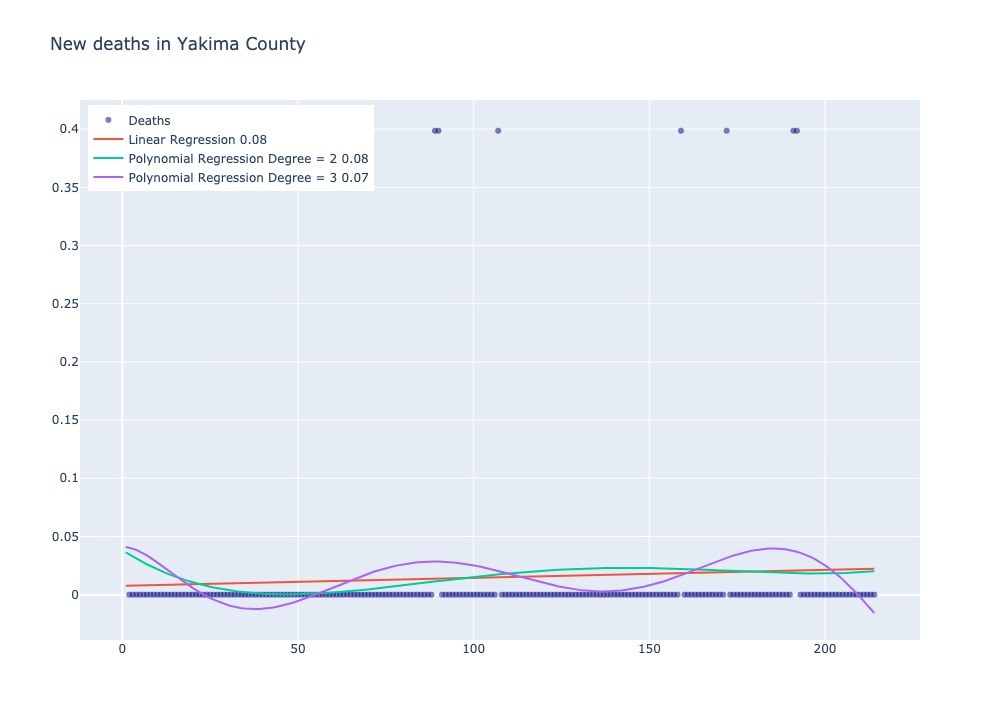

In [49]:
Image("../../../../data/stage_III/images_Ashim/fig_12.jpeg")

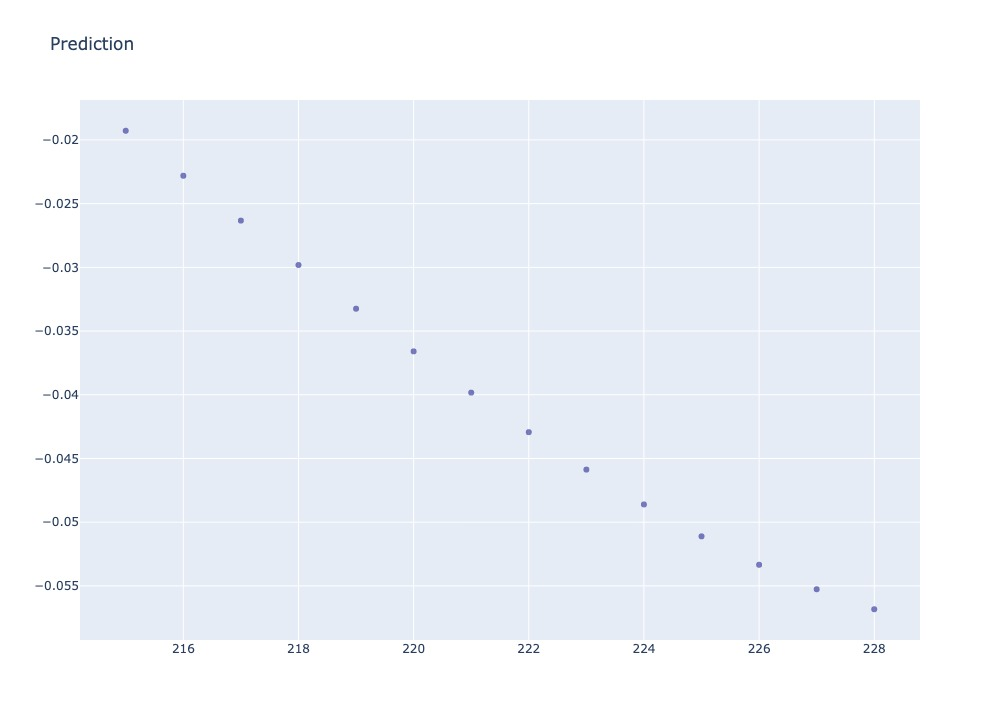

In [50]:
Image("../../../../data/stage_III/images_Ashim/fig_121212.jpeg")

## Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see what states are close and what their trend looks like.

In [51]:
h_df = pd.read_csv("../../../../data/stage_I/Definitive_Healthcare _USA_Hospital_Beds.csv")

In [52]:
h_df=h_df.groupby(by = 'HQ_STATE').sum()
h_df = h_df[['STATE_FIPS','NUM_LICENSED_BEDS','Potential_Increase_In_Bed_Capac']]
h_df['total_capacity']=h_df['NUM_LICENSED_BEDS']+h_df['Potential_Increase_In_Bed_Capac']
h_df = h_df.drop(['NUM_LICENSED_BEDS','Potential_Increase_In_Bed_Capac'], axis = 1)

In [53]:
(h_df.iloc[h_df.index=='WA']['total_capacity']).astype(int)

HQ_STATE
WA    21169
Name: total_capacity, dtype: int64

In [54]:
total_capacity_wa = 21169

In [55]:
c_df = cases.groupby(by= 'State').sum()
c_df = c_df.drop(['countyFIPS', 'StateFIPS'], axis=1)
c_df = c_df.diff(axis=1, periods=1).fillna(0)

### Point of no return for Washington.

In [56]:
point_wa = pd.DataFrame(c_df.columns.values.tolist()).reset_index()
point_wa = point_wa.rename(columns = {'index' : 'Day', 0: 'Date'});
point_wa['Day']+=1
tempwa_df = c_df[c_df.index=='WA']
point_wa['Cases']= list(tempwa_df.sum())
range_of_days=30


In [57]:
days = ['Day']
X = point_wa[days]
y = point_wa.Cases

lm_a = LinearRegression()
lm_a.fit(X,y)

print('The intercept for + geography + ', lm_a.intercept_ )
print('The coefficient for  is :', lm_a.coef_)
X_min_max = pd.DataFrame({'Day':[X.Day.min(), X.Day.max()]})
y_pred_a = lm_a.predict(X)

rmse_a = np.sqrt(mean_squared_error(y.tolist(), y_pred_a.tolist()))
print('RMSE for linear regression of  is : {}'.format(rmse_a))

#Non-Linear Regression. (degree = 2)
degree_first = 2
non_linear_a = make_pipeline(PolynomialFeatures(degree_first), LinearRegression())
poly_2_a = non_linear_a.fit(X,y)
non_linear_y_pred_a = poly_2_a.predict(X)
rmse_non_linear_a = np.sqrt(mean_squared_error(y.tolist(),non_linear_y_pred_a.tolist()))
print('RMSE for polynomial regression degree 2 of  is :{}'.format(rmse_non_linear_a))

#Non-Linear Regression. (degree = 3)
degree_second = 3
non_linear_3_a =make_pipeline(PolynomialFeatures(degree_second), LinearRegression())
poly_3 = non_linear_3_a.fit(X,y)
non_linear_y_pred_3_a = poly_3.predict(X)
rmse_non_linear_3_a = np.sqrt(mean_squared_error(y.tolist(),non_linear_y_pred_3_a.tolist()))
print('RMSE for polynomial regression degree 3 of  is : {}'.format(rmse_non_linear_3_a))
    
#Adding traces to create a graph with the best-fit lines.
trace0_a = go.Scatter(
                    x = point_wa['Day'],
                    y = point_wa['Cases'],
                    name = 'Cases',
                    mode = "markers",
                    marker = dict(color = 'rgba(0, 0, 128, 0.5)'))
trace1_a = go.Scatter(x = X['Day'].values.tolist(),
                       y = y_pred_a.tolist(),
                       mode = "lines",
                       name = 'Linear Regression %.2f' %rmse_a)
trace2_a = go.Scatter(x = X['Day'].values.tolist(),
                       y = non_linear_y_pred_a.tolist(),
                       mode = "lines",
                       name = 'Polynomial Regression Degree = 2 %.2f' %rmse_non_linear_a)
trace3_a = go.Scatter(x = X['Day'].values.tolist(),
                       y = non_linear_y_pred_3_a.tolist(),
                       mode = "lines",
                       name = 'Polynomial Regression Degree = 3 %.2f' %rmse_non_linear_3_a)
data_a = [trace0_a, trace1_a, trace2_a, trace3_a]
layout_a = go.Layout(title ='Looking at Cases and Point of no return')
fig_a = go.Figure(data=data_a, layout= layout_a)
fig_a.add_hline(y= total_capacity_wa, name = 'Point of no return')
fig_a.update_layout(autosize = False, 
                      width=1000, 
                      height = 720, 
                      legend=dict(yanchor="top", y=0.99 ,xanchor="left", x=0.01))
iplot(fig_a)
fig_a.write_image("../../../../data/stage_III/images_Ashim/fig_abc.jpeg")

The intercept for + geography +  -163.25785544621635
The coefficient for  is : [4.73643837]
RMSE for linear regression of  is : 1629.973848432865
RMSE for polynomial regression degree 2 of  is :1629.4776856348494
RMSE for polynomial regression degree 3 of  is : 1605.9132905077151


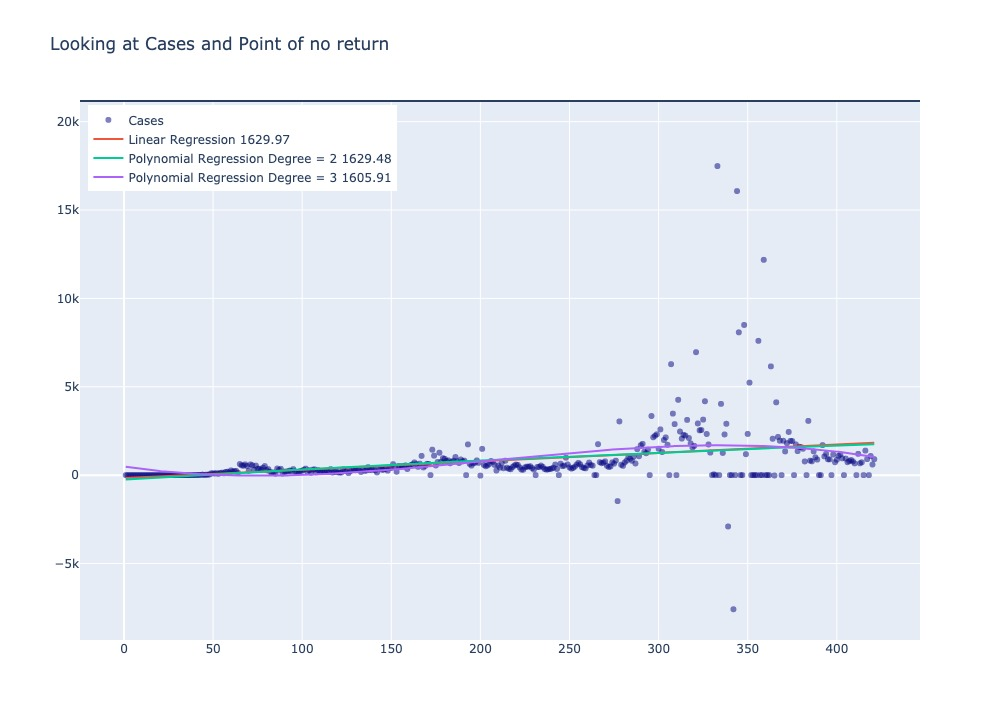

In [58]:
Image("../../../../data/stage_III/images_Ashim/fig_abc.jpeg")

## In the above graph, we can see that the state of washington has a lot of beds and even in the worst of times, they had about 2500 beds more(The black horizontal line on top symbolizes point of no return). The cases in this data is 100% of the cases in Washington and we know that only 20% of the total covid cases need hospitalization.

### Now, we add days to our dataframe and predict the cases.

In [59]:
final_day = point_wa['Day'][point_wa.index[-1]]
for i in (number+1 for number in range(range_of_days)):
    day = final_day + i
    add_days = {'Day': day, 'Cases' : 0}
    point_wa = point_wa.append(add_days, ignore_index=True)

In [60]:
new_df = point_wa.iloc[-range_of_days:]
n_day = ['Day']
X = new_df[n_day]
y = new_df.Cases

lm_a = LinearRegression()
lm_a.fit(X,y)

new_pred = lm_a.predict(X)

trace0_b = go.Scatter(
                    x = new_df['Day'],
                    y = new_pred.tolist(),
                    name = 'Cases',
                    mode = "markers",
                    marker = dict(color = 'rgba(0, 0, 128, 0.5)'))
data_b = [trace0_b]
layout_b = go.Layout(title ='Prediction for point of no return ')
fig_b = go.Figure(data=data_b, layout= layout_b)
fig_b.add_hline(y= total_capacity_wa, name = 'Point of no return')
fig_b.update_layout(autosize = False, 
                      width=1000, 
                      height = 720, 
                      legend=dict(yanchor="top", y=0.99 ,xanchor="left", x=0.01))
iplot(fig_b)
fig_b.write_image("../../../../data/stage_III/images_Ashim/fig_xyz.jpeg")

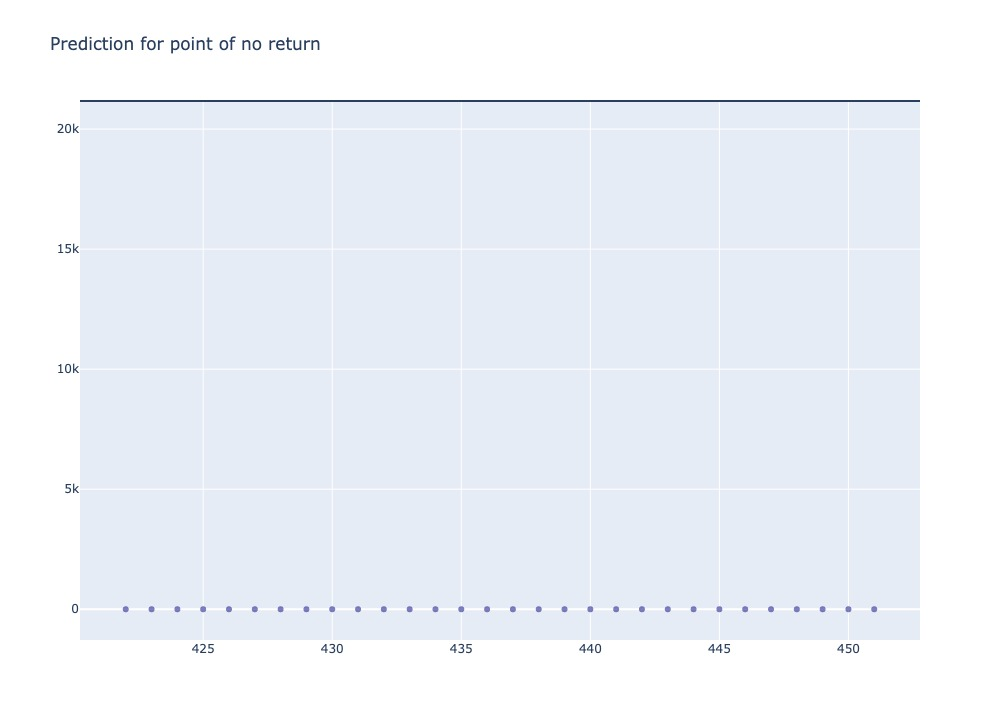

In [61]:
Image("../../../../data/stage_III/images_Ashim/fig_xyz.jpeg")

### As we can see above, in the next 30 days, Washington does not reach point of no return.

### Since, only about 20% of total covid cases require hospitalization, let's get the cases down to 20%

In [62]:
#Creating a new dataframe and cleaning it up.
cases_df = cases.groupby(by= 'State').sum()
cases_df = cases_df.diff(axis=1, periods=1).fillna(0)
cases_df = cases_df.drop(['countyFIPS', 'StateFIPS'], axis=1)
cases_df.drop(cases_df.iloc[:,0:-1],axis=1,inplace=True)
cases_df = cases_df.rename(columns = {'2021-03-17' : 'new_cases'})

#Getting the twenty percent cases
cases_df['total_cases_twenty'] = (cases_df['new_cases'] *0.2).round().astype('int')

#Let's assume the same number of people need to be in the hospital for 2 weeks and come in every day.
cases_df['total_cases_2_weeks'] = cases_df['total_cases_twenty']*14

#Creating a merged dataset to compare
merged_df = cases_df.merge(h_df, how='inner', left_index=True, right_index=True)
merged_df.drop(['STATE_FIPS'], axis=1,inplace=True)

In [63]:
merged_df['Difference'] = merged_df['total_capacity'] - merged_df['total_cases_2_weeks']

In [64]:
merged_df

new_cases  total_cases_twenty  total_cases_2_weeks  total_capacity  \
AK        167                  33                  462          1989.0   
AL        760                 152                 2128         22168.0   
AR        326                  65                  910         15010.0   
AZ        983                 197                 2758         20770.0   
CA          0                   0                    0         86266.0   
CO        626                 125                 1750         16449.0   
CT        373                  75                 1050          8291.0   
DC         81                  16                  224          5224.0   
DE        372                  74                 1036          3554.0   
FL       4613                 923                12922         69469.0   
GA       1251                 250                 3500         33242.0   
HI         69                  14                  196          3387.0   
IA          0                   0                    0         15528.0   
ID        455                  91                 1274          4500.0   
IL       1650                 330                 4620         43650.0   
IN        908                 182                 2548         17688.0   
KS        597                 119                 1666         16046.0   
KY        955                 191                 2674         20428.0   
LA        455                  91                 1274         24392.0   
MA       1689                 338                 4732         20777.0   
MD        915                 183                 2562         15242.0   
ME        196                  39                  546          4628.0   
MI       3786                 757                10598         28210.0   
MN       1038                 208                 2912         24024.0   
MO          0                   0                    0         24302.0   
MS        350                  70                  980         18950.0   
MT        139                  28                  392          3973.0   
NC       1991                 398                 5572         34205.0   
ND        133                  27                  378          3619.0   
NE        216                  43                  602          7483.0   
NH        297                  59                  826          4193.0   
NJ          0                   0                    0         31579.0   
NM        243                  49                  686          5094.0   
NV          0                   0                    0         11046.0   
NY       8976                1795                25130         62742.0   
OH       1456                 291                 4074         52112.0   
OK          0                   0                    0         17585.0   
OR        236                  47                  658         11306.0   
PA       3001                 600                 8400         48025.0   
RI       2514                 503                 7042          3818.0   
SC       1231                 246                 3444         18309.0   
SD        177                  35                  490          3536.0   
TN       1824                 365                 5110         27147.0   
TX       5104                1021                14294         91492.0   
UT        699                 140                 1960          7796.0   
VA       1373                 275                 3850         24961.0   
VT         59                  12                  168          2214.0   
WA        903                 181                 2534         21169.0   
WI        699                 140                 1960         22564.0   
WV        317                  63                  882          8701.0   
WY         96                  19                  266          2311.0   

    Difference  
AK      1527.0  
AL     20040.0  
AR     14100.0  
AZ     18012.0  
CA     86266.0  
CO     14699.0  
CT      7241.0  
DC      5000.0  
DE

# So, In this scenario, I assumed that the new_cases would be the same for nearly 2 weeks and 20% of the people would need hospitalization everyday. As people generally stay for 2 weeks, let's assume the hospitals need to have the capacity to hold the (twenty_percent * 14) number of people. If any state has a negative value in Difference column, they are weak and they have less chance of acccomodating everyone and vice versa if they have a higher positive value. For now, no state has a negative value so the states hospitals are fine for now.

# Hypothesis.<br>

<i>(The hypothesis question has been slightly modified)</i><br>

***Question : Does higher bed occupancy lead to higher deaths?***

(Higher Bed occupancy means the care quality can get low.)


# Null Hypothesis: Higher bed occupancy does not lead to higher deaths.
# Alternate Hypothesis: Higher bed occupancy does lead to higher deaths.


### First of all, let's get all the data we need.

In [75]:
enrich_df = pd.read_csv("../../../../data/stage_I/Definitive_Healthcare _USA_Hospital_Beds.csv")

In [84]:
enrich_df = enrich_df.groupby(by = 'HQ_STATE').sum()

enrich_df = enrich_df[['STATE_FIPS','BED_UTILIZATION']]
enrich_df

STATE_FIPS  BED_UTILIZATION
HQ_STATE                             
AK              56.0         9.469935
AL             122.0        52.099791
AR             540.0        41.903298
AS               0.0         0.000000
AZ             544.0        57.482765
CA            2814.0       214.933499
CO             904.0        49.110358
CT             423.0        24.222812
DC             154.0         8.744969
DE             160.0        10.669972
FL            3348.0       147.370470
GA            2353.0        88.412998
GU               0.0         1.499559
HI             450.0        12.657866
IA            2413.0        36.069655
ID             864.0        18.565466
IL            3638.0        90.343760
IN            3294.0        77.395332
KS            3280.0        56.166385
KY            2546.0        51.121259
LA            5038.0        97.586053
MA            2800.0        64.223865
MD            1632.0        39.107875
ME             897.0        20.221536
MI            4394.0        72.904227
MN            3915.0        51.471230
MO            4379.0        66.050809
MP               0.0         0.525324
MS            3192.0        45.795444
MT            2010.0        31.504907
NC            5328.0        69.406826
ND            2014.0        17.106622
NE            3193.0        27.285489
NH            1122.0        16.650781
NJ            3468.0        61.962154
NM            2100.0        22.499855
NV            2112.0        29.540993
NY            8316.0       122.246675
OH            9828.0       111.861596
OK            6360.0        58.900767
OR            2829.0        29.777110
PA           10542.0       116.682534
PR            3528.0        24.871024
RI             704.0         6.883557
SC            4230.0        43.608089
SD            3036.0        16.269877
TN            7003.0        66.850025
TX           31488.0       263.780372
UT            3038.0        23.935849
VA            6324.0        58.178110
VI               0.0         0.900898
VT             850.0         9.749227
WA            6201.0        57.018443
WI            8470.0        60.312136
WV            3618.0        27.352870
WY            1792.0         9.880087

In [77]:
#From the table above, the bed utilization average of washington is.
wa_bed_util = 57.018443

In [78]:
sc.stats.ttest_1samp(enrich_df['BED_UTILIZATION'], wa_bed_util)

Ttest_1sampResult(statistic=-0.812165741549363, pvalue=0.42019791846468113)

In [79]:
all_deaths = deaths.copy()

all_deaths = all_deaths.drop(['County Name', 'countyFIPS'],axis=1)
all_deaths = all_deaths.set_index(['State','StateFIPS'])

all_deaths = all_deaths.groupby(by='State').sum()

all_deaths.drop(all_deaths.iloc[:,0:-1],axis=1,inplace=True)

all_deaths = all_deaths.rename(columns = {'2021-03-17':'total_deaths'})

In [81]:
sc.stats.ttest_ind(enrich_df['BED_UTILIZATION'], all_deaths['total_deaths'], alternative = 'two-sided')

Ttest_indResult(statistic=-6.23854138665292, pvalue=9.443143980393611e-09)

# We can see that the p-value is less than 0.05. Hence, the null hypothesis is rejected.
# And we accept the alternate hypothesis. Hence, higher bed occupancy does lead to higher deaths.

In [72]:
#95% confidence interval
sigma = enrich_df['BED_UTILIZATION'].std()/math.sqrt(50)
stats.t.interval(alpha = 0.95,                # Confidence level
                 df = 50,                     # Degrees of freedom
                 loc = enrich_df['BED_UTILIZATION'].mean(), # Sample mean
                 scale= sigma)

(37.51815111653538, 65.7369697658889)